In [ ]:
# Install your required packages here
!pip install pandas numpy matplotlib sklearn fsspec gcsfs tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%env GOOGLE_APPLICATION_CREDENTIALS=/content/drive/My Drive/AI_Project/ai-project-2020-f4dfbc25326c.json

env: GOOGLE_APPLICATION_CREDENTIALS=/content/drive/My Drive/AI_Project/ai-project-2020-f4dfbc25326c.json


In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from google.cloud import storage
from glob import glob

In [ ]:
# define constants
bucket_name = "ai-project-2020-spotify"
client = storage.Client()
bucket = client.get_bucket(bucket_name)

In [ ]:
train_files = list(bucket.list_blobs(prefix='training_set/'))
for blob in [blob for blob in train_files if '20180715' in blob.name]:
  print(blob.name)

training_set/log_0_20180715_000000000000.csv.gz
training_set/log_1_20180715_000000000000.csv.gz
training_set/log_2_20180715_000000000000.csv.gz
training_set/log_3_20180715_000000000000.csv.gz
training_set/log_4_20180715_000000000000.csv.gz
training_set/log_5_20180715_000000000000.csv.gz
training_set/log_6_20180715_000000000000.csv.gz
training_set/log_7_20180715_000000000000.csv.gz


In [ ]:
logs = pd.read_csv(f"gs://{bucket_name}/mini/training_set/log_mini.csv.gz")
logs.columns

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end'],
      dtype='object')

In [ ]:
path_using_features_f_classif = "/content/drive/My Drive/Export/using_features_f_classif.txt"

In [ ]:
path_mydict_f_classif = "/content/drive/My Drive/Export/mydict_f_classif.txt"

In [ ]:
logs.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


In [ ]:
# Load in track features
track_features = pd.read_csv(f'gs://{bucket_name}/mini/track_features/tf_mini.csv.gz').set_index('track_id')

In [ ]:
def categorical_to_dummies(df, categorical_cols):
    """ Create dummies (one hot encoding) for each categorical variables """
    dummies = pd.get_dummies(df[categorical_cols], prefix=categorical_cols)
    return df.drop(columns=categorical_cols).join(dummies)

In [ ]:
# If you want to choose a specific day, do it first.
logs.drop(columns=['date'], inplace=True)

# Create dummies in log file
categorical_cols = ['context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end']
logs = categorical_to_dummies(logs, categorical_cols)
print(logs.shape)

(167880, 39)


In [ ]:
# Create dummies (one hot encoding) for each categorical variable in track_features
track_features = categorical_to_dummies(track_features, ['mode'])

In [ ]:
#print(track_features.dtypes)
track_features.head()

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,mode_major,mode_minor
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,0.903753,3.254327e-06,0,0.132124,-11.238,0.386100,0.541606,0.079985,166.287003,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907,1,0
t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,1.037952,8.344854e-12,0,0.163281,-13.706,0.125000,0.895874,0.083877,95.261002,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795,1,0
t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951,99.602549,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,1.004268,2.927475e-10,0,0.090115,-10.522,0.200669,0.806136,0.038777,105.185997,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496,0,1
t_070a63a0-744a-434e-9913-a97b02926a29,175.399994,1951,99.665018,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,0.975138,3.981341e-11,0,0.360924,-11.032,0.427152,0.492772,0.038337,119.441002,4,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753,1,0
t_d6990e17-9c31-4b01-8559-47d9ce476df1,369.600006,1951,99.991764,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,0.976866,2.541884e-10,0,0.189162,-6.836,0.281250,0.723808,0.032043,95.261002,4,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496,1,0


# Feature Engineering: Creating my own features

Track duration binning

In [ ]:
cut_bins = [0, 60, 90, 120, 150, 180, 210, 240, 270, 300, 600, 999999]
bin_names = ['60', '90', '120', '150', '180', '210', '240', '270', '300', 'long', 'very_long']
track_features['duration'] = pd.cut(track_features['duration'], bins=cut_bins, labels=bin_names)

In [ ]:
track_features = categorical_to_dummies(track_features, ['duration'])

In [ ]:
track_features.head()

,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,mode_major,mode_minor,duration_60,duration_90,duration_120,duration_150,duration_180,duration_210,duration_240,duration_270,duration_300,duration_long,duration_very_long
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
t_a540e552-16d4-42f8-a185-232bd650ea7d,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,0.903753,3.254327e-06,0,0.132124,-11.238,0.386100,0.541606,0.079985,166.287003,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907,1,0,0,0,1,0,0,0,0,0,0,0,0
t_67965da0-132b-4b1e-8a69-0ef99b32287c,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,1.037952,8.344854e-12,0,0.163281,-13.706,0.125000,0.895874,0.083877,95.261002,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795,1,0,0,0,0,0,0,1,0,0,0,0,0
t_0614ecd3-a7d5-40a1-816e-156d5872a467,1951,99.602549,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,1.004268,2.927475e-10,0,0.090115,-10.522,0.200669,0.806136,0.038777,105.185997,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496,0,1,0,0,0,0,1,0,0,0,0,0,0
t_070a63a0-744a-434e-9913-a97b02926a29,1951,99.665018,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,0.975138,3.981341e-11,0,0.360924,-11.032,0.427152,0.492772,0.038337,119.441002,4,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753,1,0,0,0,0,0,1,0,0,0,0,0,0
t_d6990e17-9c31-4b01-8559-47d9ce476df1,1951,99.991764,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,0.976866,2.541884e-10,0,0.189162,-6.836,0.281250,0.723808,0.032043,95.261002,4,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496,1,0,0,0,0,0,0,0,0,0,0,1,0


Decades binning

In [ ]:
cut_bins = [0, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
bin_names = ['60s', '70s', '80s', '90s', '00s', '10s', '20s']
track_features['release_year'] = pd.cut(track_features['release_year'], bins=cut_bins, labels=bin_names)

In [ ]:
track_features = categorical_to_dummies(track_features, ['release_year'])

In [ ]:
track_features.head()

,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,mode_major,mode_minor,duration_60,duration_90,duration_120,duration_150,duration_180,duration_210,duration_240,duration_270,duration_300,duration_long,duration_very_long,release_year_60s,release_year_70s,release_year_80s,release_year_90s,release_year_00s,release_year_10s,release_year_20s
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
t_a540e552-16d4-42f8-a185-232bd650ea7d,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,0.903753,3.254327e-06,0,0.132124,-11.238,0.386100,0.541606,0.079985,166.287003,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
t_67965da0-132b-4b1e-8a69-0ef99b32287c,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,1.037952,8.344854e-12,0,0.163281,-13.706,0.125000,0.895874,0.083877,95.261002,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
t_0614ecd3-a7d5-40a1-816e-156d5872a467,99.602549,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,1.004268,2.927475e-10,0,0.090115,-10.522,0.200669,0.806136,0.038777,105.185997,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
t_070a63a0-744a-434e-9913-a97b02926a29,99.665018,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,0.975138,3.981341e-11,0,0.360924,-11.032,0.427152,0.492772,0.038337,119.441002,4,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
t_d6990e17-9c31-4b01-8559-47d9ce476df1,99.991764,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,0.976866,2.541884e-10,0,0.189162,-6.836,0.281250,0.723808,0.032043,95.261002,4,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [ ]:
#print(track_features.release_year.unique())

Hour of Day

In [ ]:
cut_bins = [0, 12, 18, 24]
bin_names = ['morning', 'afternoon', 'evening']
logs['hour_of_day'] = pd.cut(logs['hour_of_day'], bins=cut_bins, labels=bin_names)

In [ ]:
logs = categorical_to_dummies(logs, ['hour_of_day'])

In [ ]:
logs.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,premium,context_type_catalog,context_type_charts,context_type_editorial_playlist,context_type_personalized_playlist,context_type_radio,context_type_user_collection,hist_user_behavior_reason_start_appload,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_end_backbtn,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_endplay,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone,hour_of_day_morning,hour_of_day_afternoon,hour_of_day_evening
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,True,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,True,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,True,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,True,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,True,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


# **Normalize**

In [ ]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
track_features = normalize(track_features)

In [ ]:
track_features.head(n=5)

,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,mode_major,mode_minor,duration_60,duration_90,duration_120,duration_150,duration_180,duration_210,duration_240,duration_270,duration_300,duration_long,duration_very_long,release_year_60s,release_year_70s,release_year_80s,release_year_90s,release_year_00s,release_year_10s,release_year_20s
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
t_a540e552-16d4-42f8-a185-232bd650ea7d,0.997537,0.459974,0.524522,0.519179,0.405875,0.232258,0.817810,0.819200,3.256285e-06,0.0,0.132621,0.791154,0.386100,0.562795,0.083196,0.760082,0.8,0.935521,0.530185,0.354452,0.533069,0.615072,0.967127,0.550818,0.256542,0.140865,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
t_67965da0-132b-4b1e-8a69-0ef99b32287c,0.996937,0.920140,0.423278,0.560904,0.498740,0.281311,0.154277,0.940845,8.349875e-12,0.0,0.163895,0.751111,0.125000,0.930923,0.087244,0.435429,0.6,0.359678,0.617285,0.123334,0.645361,0.826081,0.727899,0.394562,0.307239,0.211411,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
t_0614ecd3-a7d5-40a1-816e-156d5872a467,0.960180,0.816315,0.430010,0.522604,0.499136,0.258749,0.358857,0.910311,2.929237e-10,0.0,0.090453,0.802771,0.200669,0.837675,0.040334,0.480795,0.8,0.726776,0.556952,0.179595,0.799604,0.731341,0.748303,0.570567,0.204794,0.254787,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
t_070a63a0-744a-434e-9913-a97b02926a29,0.966439,0.398530,0.404813,0.370135,0.560664,0.184503,0.514649,0.883907,3.983736e-11,0.0,0.362280,0.794497,0.427152,0.512050,0.039876,0.545954,0.8,0.859083,0.565430,0.430533,0.515945,0.485926,0.854102,0.628273,0.276218,0.203441,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
t_d6990e17-9c31-4b01-8559-47d9ce476df1,0.999175,0.731908,0.374921,0.344559,0.490424,0.179412,0.721531,0.885473,2.543413e-10,0.0,0.189873,0.862576,0.281250,0.752126,0.033329,0.435429,0.8,0.562348,0.610584,0.417373,0.425344,0.411285,0.907282,0.700229,0.201803,0.244448,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Joining tables**

In [ ]:
# Join track features and logs
#data = logs.join(track_features, on='track_id_clean', how='left').drop(columns=['track_id_clean'])
data = logs.join(track_features, on='track_id_clean', how='left')
data.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,premium,context_type_catalog,context_type_charts,context_type_editorial_playlist,context_type_personalized_playlist,context_type_radio,context_type_user_collection,hist_user_behavior_reason_start_appload,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_end_backbtn,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_endplay,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone,hour_of_day_morning,hour_of_day_afternoon,...,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,mode_major,mode_minor,duration_60,duration_90,duration_120,duration_150,duration_180,duration_210,duration_240,duration_270,duration_300,duration_long,duration_very_long,release_year_60s,release_year_70s,release_year_80s,release_year_90s,release_year_00s,release_year_10s,release_year_20s
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,True,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,...,0.553533,0.938174,3.486565e-03,0.090909,0.681102,0.866778,0.546784,0.333214,0.072515,0.612616,0.8,0.152256,0.149403,0.775233,0.723667,0.444439,0.361692,0.724188,0.224763,0.555240,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,True,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,...,0.726918,0.929680,1.031935e-07,0.636364,0.104714,0.887189,0.824766,0.136532,0.063613,0.594391,0.8,0.337156,0.199102,0.763273,0.782711,0.407144,0.335835,0.762672,0.217882,0.532727,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,True,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,...,0.563078,0.933152,2.660635e-08,0.909091,0.136286,0.878687,0.774327,0.308540,0.047175,0.662909,0.8,0.373866,0.185041,0.769535,0.740241,0.403543,0.379156,0.760392,0.146614,0.543857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,True,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,...,0.529549,0.900569,6.602358e-06,0.090909,0.104111,0.847649,0.630996,0.626873,0.239166,0.511859,0.8,0.649426,0.203253,0.738944,0.767114,0.408897,0.330542,0.782603,0.218405,0.592732,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,True,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,...,0.650137,0.906960,2.067893e-06,0.727273,0.121296,0.893679,0.759465,0.176804,0.250653,0.672065,0.8,0.652927,0.123751,0.746175,0.709167,0.474547,0.361737,0.693072,0.132722,0.544191,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
#data = pd.read_csv('/content/drive/My Drive/Export/log_0_20180715_000000000000_JOINED_FEATURES_COSINE_SIMILARITY_SECOND_HALF.csv')

In [ ]:
print(data.dtypes)

session_id                                     object
session_position                                int64
session_length                                  int64
track_id_clean                                 object
skip_1                                           bool
skip_2                                           bool
skip_3                                           bool
not_skipped                                      bool
context_switch                                  int64
no_pause_before_play                            int64
short_pause_before_play                         int64
long_pause_before_play                          int64
hist_user_behavior_n_seekfwd                    int64
hist_user_behavior_n_seekback                   int64
hist_user_behavior_is_shuffle                    bool
premium                                          bool
context_type_catalog                            uint8
context_type_charts                             uint8
context_type_editorial_playl

# Cosine Similarity

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 800)

In [ ]:
from tqdm import tqdm

In [ ]:
data.columns

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'premium', 'context_type_catalog', 'context_type_charts',
       'context_type_editorial_playlist', 'context_type_personalized_playlist',
       'context_type_radio', 'context_type_user_collection',
       'hist_user_behavior_reason_start_appload',
       'hist_user_behavior_reason_start_backbtn',
       'hist_user_behavior_reason_start_clickrow',
       'hist_user_behavior_reason_start_endplay',
       'hist_user_behavior_reason_start_fwdbtn',
       'hist_user_behavior_reason_start_playbtn',
       'hist_user_behavior_reason_start_remote',
       'hist_user_behavior_reason_start_trackdone',
       'hist_user_behavior_reason_start_trackerror

In [ ]:
# All songs that have been skipped:
skipped_songs_data = data[data['skip_2'] == 1]
second_half_songs_data = data[data['session_position'] > 0.5 * data['session_length']]

In [ ]:
cosine_distance_columns = ['duration_60', 'duration_90', 'duration_120', 'duration_150',
       'duration_180', 'duration_210', 'duration_240', 'duration_270',
       'duration_300', 'duration_long', 'duration_very_long', 'release_year_60s', 'release_year_70s', 'release_year_80s',
       'release_year_90s', 'release_year_00s', 'release_year_10s',
       'release_year_20s', 'us_popularity_estimate', 'acousticness',
       'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
       'energy', 'flatness', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mechanism', 'organism', 'speechiness', 'tempo', 'time_signature',
       'valence', 'acoustic_vector_0', 'acoustic_vector_1',
       'acoustic_vector_2', 'acoustic_vector_3', 'acoustic_vector_4',
       'acoustic_vector_5', 'acoustic_vector_6', 'acoustic_vector_7']
skipped_songs_data[cosine_distance_columns]
second_half_songs_data[cosine_distance_columns]

,duration_60,duration_90,duration_120,duration_150,duration_180,duration_210,duration_240,duration_270,duration_300,duration_long,duration_very_long,release_year_60s,release_year_70s,release_year_80s,release_year_90s,release_year_00s,release_year_10s,release_year_20s,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.999346,0.054664,0.601350,0.661351,0.815093,0.295729,0.639806,0.952434,4.768101e-05,0.363636,0.343130,0.900039,0.851399,0.116283,0.029053,0.603296,0.8,0.037999,0.267278,0.721680,0.738211,0.386623,0.359482,0.800521,0.234082,0.574678
11,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.987302,0.509305,0.612118,0.743495,0.645127,0.358169,0.543803,0.917759,7.045399e-08,0.090909,0.262584,0.822322,0.219512,0.683920,0.431295,0.623613,1.0,0.650360,0.032360,0.775412,0.810567,0.555427,0.387838,0.730417,0.282973,0.583969
12,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.999572,0.444375,0.591302,0.712509,0.804802,0.337845,0.411746,0.938717,7.433323e-05,0.181818,0.219380,0.822517,0.551813,0.462779,0.378756,0.621355,0.8,0.306547,0.156836,0.713919,0.745130,0.477010,0.366214,0.735597,0.178900,0.568213
13,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.999895,0.058385,0.684689,0.750654,0.774307,0.334297,0.441180,0.934620,2.468478e-09,0.000000,0.045949,0.840267,0.462094,0.397540,0.266750,0.393523,0.8,0.538393,0.128686,0.738998,0.794455,0.484420,0.385668,0.735954,0.168771,0.553710
14,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.997136,0.778043,0.623427,0.688919,0.835615,0.307904,0.447291,0.926976,1.484733e-05,0.090909,0.093495,0.802122,0.673130,0.617871,0.130647,0.503069,0.8,0.413243,0.158524,0.795426,0.806452,0.417175,0.371095,0.794022,0.206595,0.543615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.992626,0.100650,0.565205,0.587774,0.573973,0.260076,0.875477,0.889853,3.248933e-04,0.181818,0.245014,0.877681,0.430147,0.425138,0.047660,0.710986,0.8,0.891331,0.288468,0.560750,0.717566,0.552762,0.648058,0.777702,0.325582,0.526673
167876,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.990493,0.248232,0.606936,0.650495,0.713837,0.286617,0.529067,0.929269,6.182660e-08,0.090909,0.323527,0.854415,0.438776,0.450598,0.037986,0.614453,0.8,0.701831,0.316683,0.565430,0.727230,0.519560,0.701648,0.792531,0.305869,0.452292
167877,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.991545,0.299660,0.713736,0.750586,0.803505,0.322163,0.952010,0.852063,4.263507e-04,0.090909,0.275946,0.897183,0.896789,0.232001,0.098711,0.703828,0.8,0.961426,0.240484,0.599104,0.715677,0.556236,0.551634,0.767599,0.356566,0.559123
167878,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.988181,0.038271,0.496944,0.513079,0.654865,0.236781,0.872095,0.891281,4.343627e-03,0.363636,0.047703,0.905344,0.627530,0.275109,0.078458,0.399799,0.8,0.743119,0.217783,0.625705,0.645150,0.501888,0.419127,0.686076,0.151305,0.551478


In [ ]:
mean_skipped_song = skipped_songs_data[cosine_distance_columns].mean().tolist()
mean_second_half_songs = second_half_songs_data[cosine_distance_columns].mean().tolist()

In [ ]:
# What variable would be highly correlated or unnecessary?
mean_skipped_song
mean_second_half_songs

[0.003489027771251351,
 0.007659414501198252,
 0.02149804990366994,
 0.06193317983177482,
 0.13344062779004745,
 0.2539236877966261,
 0.2598797049010855,
 0.13575489873596167,
 0.057774540670081295,
 0.06368356750152718,
 0.0009633005967764673,
 0.0018443682157793337,
 0.011406888774023778,
 0.01831445890700625,
 0.012663878577134533,
 0.036805131337813074,
 0.07593628118979372,
 0.8430289929984494,
 0.9741275566994493,
 0.21872172716362182,
 0.553012241887742,
 0.596182402307945,
 0.6791296901597593,
 0.2809987427088175,
 0.6268341620784712,
 0.913695735640304,
 0.032210899336388155,
 0.47349535009886773,
 0.19106792629628053,
 0.8591564593221308,
 0.5967214908124369,
 0.3614257698507481,
 0.14814909219527342,
 0.5604267077864553,
 0.7896198486924326,
 0.4609196291706396,
 0.29503983446517373,
 0.7134477811761989,
 0.7059959751993727,
 0.42092271474592957,
 0.46240279936216877,
 0.7486333627957579,
 0.26634220665172054,
 0.4867246474123027]

In [ ]:
tqdm.pandas()

In [ ]:
data['similarity_mean_skipped_song'] = data[cosine_distance_columns].progress_apply(lambda x: cosine_similarity([mean_skipped_song], [x.tolist()])[0][0], axis=1)

100%|██████████| 167880/167880 [00:58<00:00, 2878.63it/s]


In [ ]:
data['similarity_mean_second_half_songs'] = data[cosine_distance_columns].progress_apply(lambda x: cosine_similarity([mean_second_half_songs], [x.tolist()])[0][0], axis=1)

100%|██████████| 167880/167880 [00:58<00:00, 2859.63it/s]


In [ ]:
data['similarity_mean_skipped_song'].min()

0.4939139141008396

In [ ]:
data['similarity_mean_second_half_songs'].min()

0.4947371808845085

In [ ]:
data[data['similarity_mean_skipped_song'] == 0.8639864543014858]

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,premium,context_type_catalog,context_type_charts,context_type_editorial_playlist,context_type_personalized_playlist,context_type_radio,context_type_user_collection,hist_user_behavior_reason_start_appload,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_end_backbtn,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_endplay,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone,hour_of_day_morning,hour_of_day_afternoon,hour_of_day_evening,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,mode_major,mode_minor,duration_60,duration_90,duration_120,duration_150,duration_180,duration_210,duration_240,duration_270,duration_300,duration_long,duration_very_long,release_year_60s,release_year_70s,release_year_80s,release_year_90s,release_year_00s,release_year_10s,release_year_20s,similarity_mean_skipped_song,similarity_mean_second_half_songs


In [ ]:
data[data['similarity_mean_second_half_songs'] == 0.5940561543366462]

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,premium,context_type_catalog,context_type_charts,context_type_editorial_playlist,context_type_personalized_playlist,context_type_radio,context_type_user_collection,hist_user_behavior_reason_start_appload,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_end_backbtn,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_endplay,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone,hour_of_day_morning,hour_of_day_afternoon,hour_of_day_evening,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,mode_major,mode_minor,duration_60,duration_90,duration_120,duration_150,duration_180,duration_210,duration_240,duration_270,duration_300,duration_long,duration_very_long,release_year_60s,release_year_70s,release_year_80s,release_year_90s,release_year_00s,release_year_10s,release_year_20s,similarity_mean_skipped_song,similarity_mean_second_half_songs


# **Splitting and stacking**

In [ ]:
def split_sessions(data, perc_in=0.6):
    """ Split interactions into train and test sessions. """
    sessions = data['session_id'].unique()
    amt_in = int(perc_in * len(sessions))
    sessions_in = np.random.choice(sessions, amt_in, replace=False)
    sessions_out = np.array(list(set(sessions) - set(sessions_in)))
    indexed_data = data.set_index('session_id')
    data_in = indexed_data.loc[sessions_in]
    data_out = indexed_data.loc[sessions_out]
    return data_in, data_out

In [ ]:
train, val = split_sessions(data, 0.6)
print(len(train), len(val))

100799 67081


In [ ]:
def stack_sessions(df):
    """
    Turn matrix representation into vector by stacking the listen events together (as columns) 
    For example:
    session_id session_position feature1 feature2
    a          1                ~        ~
    a          2                ~        ~
    b          1                ~        ~
    b          2                ~        ~
    b          3                ~        ~
    
    Turns into:
    session_id 1_feature1 1_feature2 2_feature1 2_feature2 3_feature1 3_feature2
    a          ~          ~          ~          ~          Nan        Nan
    b          ~          ~          ~          ~          ~          ~
    """
    columns = list(df.columns)
    columns.remove('session_id')
    columns.remove('session_position')
    sessions = df.pivot(index='session_id', columns='session_position', values=columns)
    return sessions

In [ ]:
# Columns to drop from the second part of the session, because this information is not available for prediction.
# Note that you could still use this information for learning embeddings etc.
drop_cols = list(logs.columns)
drop_cols.remove('session_id')
drop_cols.remove('session_position')
drop_cols.remove('track_id_clean')

In [ ]:
def split_df(df):
    """
    Split df in data and labels part. First half of session is stacked and joined to each song in the second half of the session.
    Listening information is removed from second half, as it will not be available for prediction.
    """
    first = df.loc[df['session_position']*2 <= df['session_length']].reset_index().drop(columns=['session_length'])
    second = df.loc[df['session_position']*2 > df['session_length']].reset_index()
    # skip_2 is ground truth
    truth = second['skip_2']
    second.drop(columns=drop_cols, inplace=True)
    first_stacked = stack_sessions(first)
    data = second.join(first_stacked, how='left', on='session_id')
    return data, truth

In [ ]:
# Wrangle the train and validation sets in the right format.
train_data, train_labels = split_df(train)
val_data, val_labels = split_df(val)

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


Dropping track_ids

In [ ]:
#print(train_data.dtypes)
#train_data[('track_id_clean',2)]

In [ ]:
track_ids_data = train_data[['track_id_clean', ('track_id_clean',1), ('track_id_clean',2), ('track_id_clean',3), ('track_id_clean',4), ('track_id_clean',5), ('track_id_clean',6), ('track_id_clean',7), ('track_id_clean',8), ('track_id_clean',9), ('track_id_clean',10)]]
val_ids_data = val_data[['track_id_clean', ('track_id_clean',1), ('track_id_clean',2), ('track_id_clean',3), ('track_id_clean',4), ('track_id_clean',5), ('track_id_clean',6), ('track_id_clean',7), ('track_id_clean',8), ('track_id_clean',9), ('track_id_clean',10)]]

In [ ]:
print(len(track_ids_data.columns))

11


In [ ]:
#print('Before:', train_data.shape)
for i in range(len(track_ids_data.columns)):
  train_data = train_data.drop(track_ids_data.columns[i], axis = 1)
  val_data = val_data.drop(track_ids_data.columns[i], axis = 1)
#print('After:', train_data.shape)

Fill up missing data

In [ ]:
train_data2 = train_data.drop(columns=['session_id'])
train_data2 = train_data2.interpolate(method='linear')

In [ ]:
#print(train_data2.dtypes)

In [ ]:
cols = list(train_data2.columns)

In [ ]:
# changing the datatype of the column
for column in cols:
    train_data2[column] = pd.to_numeric(train_data2[column])

In [ ]:
train_data2 = train_data2.interpolate()

In [ ]:
train_data2 = train_data2.interpolate(method ='linear', limit_direction='backward')

In [ ]:
train_data2.isnull().values.any()

False

**Train data from saved csv file.** 

In [ ]:
#train_data.to_csv('/content/drive/My Drive/Export/train_data_2.csv', index = False)

In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/Export/train_data_new.csv')

In [ ]:
#train_data2.to_csv('/content/drive/My Drive/Export/train_data2_2.csv', index = False)

In [ ]:
train_data2 = pd.read_csv('/content/drive/My Drive/Export/train_data2_new.csv')

In [ ]:
#train_data2.head()

In [ ]:
#val_data.to_csv('/content/drive/My Drive/Export/val_data_2.csv', index = False)

In [ ]:
val_data = pd.read_csv('/content/drive/My Drive/Export/val_data_new.csv')

In [ ]:
#train_labels.to_csv('/content/drive/My Drive/Export/train_labels_2.csv', index = False)

In [ ]:
train_labels = pd.read_csv('/content/drive/My Drive/Export/train_labels_new.csv')

In [ ]:
#val_labels.to_csv('/content/drive/My Drive/Export/val_labels_2.csv', index = False)

In [ ]:
val_labels = pd.read_csv('/content/drive/My Drive/Export/val_labels_new.csv')

In [ ]:
print(train_data2.shape)

(50976, 888)


In [ ]:
from sklearn.impute import SimpleImputer

# Fill in NaN values with mean of column. This choice *should* depend on your decision of classifier and feature encoding. Not every approach has the same assumptions about the data.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_data_imp = imp.fit_transform(train_data.drop(columns=['session_id']))
val_data_imp = imp.transform(val_data.drop(columns=['session_id']))

# Feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif
from matplotlib import pyplot

Mutual_info_classif

In [ ]:
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [ ]:
# feature selection
train_data_fs, test_data_fs, fs = select_features(train_data2, train_labels.values, val_data_imp)

In [ ]:
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

f_classif

In [ ]:
def select_features_2(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [ ]:
train_data_fs_f_classif, test_data_fs_f_classif, fs_f_classif = select_features_2(train_data2, train_labels.values, val_data_imp)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 87  97 107 117 259 261 262 263 264 265 266 283 285 286 309 316 327 328
 329 330 331 332 333 334 335 336] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Feature 0: 57.409172
Feature 1: 4.905515
Feature 2: 29.087041
Feature 3: 0.006383
Feature 4: 0.926089
Feature 5: 1.554490
Feature 6: 2.419004
Feature 7: 8.209429
Feature 8: 1.047965
Feature 9: 11.757842
Feature 10: 0.231150
Feature 11: 0.489247
Feature 12: 9.773740
Feature 13: 0.924444
Feature 14: 3.695814
Feature 15: 17.111720
Feature 16: 1.484967
Feature 17: 0.575014
Feature 18: 1.430372
Feature 19: 34.859497
Feature 20: 10.412121
Feature 21: 7.317694
Feature 22: 9.518836
Feature 23: 3.122565
Feature 24: 10.723923
Feature 25: 19.802035
Feature 26: 1.028257
Feature 27: 6.897178
Feature 28: 6.897178
Feature 29: 5.979133
Feature 30: 4.792022
Feature 31: 8.111017
Feature 32: 6.423898
Feature 33: 10.223295
Feature 34: 0.004062
Feature 35: 0.181613
Feature 36: 5.255690
Feature 37: 7.134282
Feature 38: 4.515066
Feature 39: 0.844627
Feature 40: 0.792209
Feature 41: 0.092551
Feature 42: 0.166342
Feature 43: 6.671228
Feature 44: 2.151929
Feature 45: 8.225262
Feature 46: 12.397933
Feature 47: 1

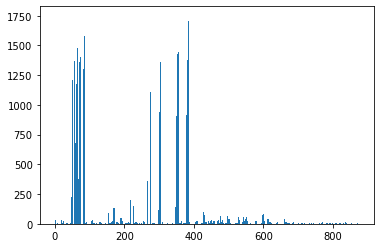

In [ ]:
# what are scores for the features
for i in range(len(fs_f_classif.scores_)):
    print('Feature %d: %f' % (i, fs_f_classif.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs_f_classif.scores_))], fs_f_classif.scores_)
pyplot.show()

Dictionary

In [ ]:
# create dictionary

# f_classif
n = 150
myDict = {}
for i in range(len(fs_f_classif.scores_)):
    if pd.notna(fs_f_classif.scores_[i]) : #only adding the values with numbers
        myDict[i] = fs_f_classif.scores_[i]

# mutual_info_classif
#n = 300
#myDict = {}
#for i in range(len(fs.scores_)):
#    if pd.notna(fs.scores_[i]) : #only adding the values with numbers
#        myDict[i] = fs.scores_[i]

In [ ]:
# sort dic based on values (not keys)
myDict_sort = {k: v for k, v in sorted(myDict.items(), key=lambda item: item[1], reverse = True)}

Code to write and read (saved) dictionary

In [ ]:
path_mydict_f_classif_2 = "/content/drive/My Drive/Export/mydict_f_classif_2.txt"
#path_mydict_f_classif = "/content/drive/My Drive/Export/mydict_f_classif.txt"

In [ ]:
#f = open(path_mydict_f_classif_2, "w+") #a+ append, w+ new write

In [ ]:
#for element in myDict_sort:
#  f.write(str(element))
#  f.write("\n")
#  f.write(str(myDict_sort.get(element)))
#  f.write("\n")

In [ ]:
#f.close()

In [ ]:
lijst = []
with open(path_mydict_f_classif_2) as uf:
  for line in uf:
    lijst.append(line)

#lijst = []
#with open(path_mydict_f_classif) as uf:
#  for line in uf:
#    lijst.append(line)

In [ ]:
uf.close()

In [ ]:
#print(lijst)

In [ ]:
myDict_sort = {}
j = 0
for i in range(int(len(lijst)/2)):
  myDict_sort[int(lijst[j])] = float(lijst[j+1])
  j += 2

In [ ]:
print(myDict_sort)

{386: 1741.3247816544904, 383: 1733.538943141252, 86: 1709.9930759874667, 385: 1703.7930592097794, 73: 1668.1777068975116, 83: 1647.648603162324, 76: 1624.1447007347113, 85: 1580.9186570746858, 75: 1550.8262085019055, 355: 1528.4577811074053, 65: 1476.3422871645923, 63: 1451.2702666937635, 356: 1446.6915244509037, 353: 1427.3777502505066, 384: 1418.7567599727993, 84: 1414.0890165960395, 381: 1411.1600850456834, 66: 1404.6316119675178, 74: 1398.681819266019, 382: 1380.2990656846873, 56: 1369.2997371998101, 81: 1362.96187431772, 304: 1360.5674843748184, 71: 1359.2556953525586, 55: 1332.698809426836, 306: 1324.28627816562, 354: 1320.6777013851452, 352: 1313.8660058026337, 72: 1309.969732892476, 82: 1301.9729843536527, 54: 1259.7292333632838, 305: 1239.8951156123576, 351: 1229.635932952617, 276: 1228.7650433460528, 64: 1221.6576828271473, 51: 1208.53017913705, 61: 1199.5398909250855, 62: 1178.861106247196, 53: 1172.9212112815378, 302: 1153.73202293429, 52: 1109.6775559193832, 275: 1107.104

**Feature selection - using features**

In [ ]:
# select top 200/300 features
n = 300
#n = 150
mylist = list(myDict_sort.keys())
using_features = np.sort(mylist[0:n])

Code to write and read the list of using features

In [ ]:
#f = open(path, "w+") #a+ append, w+ write

In [ ]:
#for feature in using_features:
#  f.write(str(feature))
#  f.write("\n")

In [ ]:
#f.close()

In [ ]:
#uf = open(path, "r")

In [ ]:
#uf.close()

In [ ]:
using_features = []
with open(path_using_features_f_classif) as uf:
  for line in uf:
    using_features.append(int(line))

In [ ]:
uf.close()

In [ ]:
print(using_features)

[0, 1, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 92, 136, 137, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 181, 182, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 361, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 383, 386, 389, 411, 412, 413, 414, 415, 416, 417, 419, 447, 461, 481, 482, 484, 485, 487, 511, 512, 513, 515, 516, 522, 532, 533, 536, 537, 581, 582, 583, 585, 586, 589, 591, 592, 593, 594, 595, 596, 597, 598, 641, 646]


In [ ]:
# What features do we have in total?
for i in range(len(train_data.columns)):
  print(i, ": ", train_data.columns[i])

0 :  session_id
1 :  session_position
2 :  us_popularity_estimate
3 :  acousticness
4 :  beat_strength
5 :  bounciness
6 :  danceability
7 :  dyn_range_mean
8 :  energy
9 :  flatness
10 :  instrumentalness
11 :  key
12 :  liveness
13 :  loudness
14 :  mechanism
15 :  organism
16 :  speechiness
17 :  tempo
18 :  time_signature
19 :  valence
20 :  acoustic_vector_0
21 :  acoustic_vector_1
22 :  acoustic_vector_2
23 :  acoustic_vector_3
24 :  acoustic_vector_4
25 :  acoustic_vector_5
26 :  acoustic_vector_6
27 :  acoustic_vector_7
28 :  mode_major
29 :  mode_minor
30 :  duration_60
31 :  duration_90
32 :  duration_120
33 :  duration_150
34 :  duration_180
35 :  duration_210
36 :  duration_240
37 :  duration_270
38 :  duration_300
39 :  duration_long
40 :  duration_very_long
41 :  release_year_60s
42 :  release_year_70s
43 :  release_year_80s
44 :  release_year_90s
45 :  release_year_00s
46 :  release_year_10s
47 :  release_year_20s
48 :  similarity_mean_skipped_song
49 :  similarity_mean_

***Adding features manually***

In [ ]:
# (duration 60,3): 699 - (duration very long, 10): 807

In [ ]:
#added always - in case of first model
durations_and_all = np.array([381,382,384,385,387,388,390,4,5,10,14])
using_features = np.append(using_features, durations_and_all)

In [ ]:
#add duration - second model

# top 400 add-ons
#durations = np.append(np.arange(699,703),np.array([705]))
#durations = np.append(durations,np.arange(708,727))
#durations = np.append(durations,np.arange(728,730))
#durations = np.append(durations,np.array([731]))
#durations = np.append(durations,np.arange(733,737))
#durations = np.append(durations,np.arange(738,747))
#durations = np.append(durations,np.arange(748,752))
#durations = np.append(durations,np.arange(753,757))
#durations = np.append(durations,np.arange(758,763))
#durations = np.append(durations,np.arange(764,771))
#durations = np.append(durations,np.arange(773,777))
#durations = np.append(durations,np.arange(780,791))
#durations = np.append(durations,np.array([792]))
#durations = np.append(durations,np.arange(794,808))
#durations = np.append(durations,np.arange(29,33))
#durations = np.append(durations,np.arange(34,40))
#durations = np.append(durations,np.array([3,8]))

# top 300 add-ons
durations = np.append(np.arange(699,706),np.arange(708,727))
durations = np.append(durations,np.arange(728,732))
durations = np.append(durations,np.arange(733,747))
durations = np.append(durations,np.arange(748,771))
durations = np.append(durations,np.arange(772,777))
durations = np.append(durations,np.arange(779,808))
durations = np.append(durations,np.arange(29,40))
durations = np.append(durations,np.array([3,8,12]))
durations = np.append(durations,np.arange(879,899))
#print(durations)
using_features = np.append(using_features, durations)

In [ ]:
print(len(using_features))

435


In [ ]:
# Make train_data2 such that only necessary features are left
train_data_imp2 = np.zeros((len(train_data_imp),len(using_features)))

j = 0
for i in using_features :
    train_data_imp2[:,j] = train_data_imp[:,i]
    j += 1

#print(len(train_data_imp2))
#j = 0
#for col_name in train_data2.columns[using_features]: 
#    print(j, ": ", col_name)
#    j += 1
#print(train_data2.dtypes[using_features])

In [ ]:
# train_data from the using_features + the columns from track_ids_data
train_data_new = train_data['session_id']
# val_data from the using_features + the columns from val_ids_data
val_data_new = val_data['session_id']


for col_name in train_data.columns[using_features] :
    train_data_new = pd.concat([train_data_new, train_data[col_name]], axis = 1, sort = False)
    val_data_new = pd.concat([val_data_new, val_data[col_name]], axis = 1, sort = False)


In [ ]:
#train_data_new = pd.concat([train_data_new, track_ids_data], axis=1, sort=False)
#val_data_new = pd.concat([val_data_new, val_ids_data], axis=1, sort=False)

#train_data_new.to_csv('/content/drive/My Drive/Export/train_data_all.csv', index = False)
#val_data_new.to_csv('/content/drive/MyDrive/Export/val_data_all.csv', index = False)

# Gradient Boosting Tree

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time

In [ ]:
#print(train_labels.values)

In [ ]:
# Train the GBT
#start_time = time.clock()
# variables: n_estimators: 100,200,500; max_depth: 3,5,10,20
gbt = GradientBoostingClassifier(n_estimators = 100, max_depth = 5, min_samples_split=2, min_samples_leaf=1)
gbt.fit(train_data_imp2, train_labels.values)
#print(time.clock() - start_time, "seconds")

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
#import pickle

#gbt_path = "/content/drive/My Drive/Export/gbt.pickle"
#pickle.dump(gbt, open(gbt_path, 'wb'))

In [ ]:
# Predict the second half of the data

val_data_imp2 = np.zeros((len(val_data_imp),len(using_features)))
j = 0
for i in using_features :
    val_data_imp2[:,j] = val_data_imp[:,i].T
    j += 1

predictions = gbt.predict(val_data_imp2)

In [ ]:
# Convert from flattened format back to session based format (for calculation of MAA metric).
prediction_df = val_data[['session_id']]
prediction_df.loc[:, 'prediction'] = predictions
predictions_list = prediction_df.groupby('session_id')['prediction'].apply(list)

labels_df = val_data[['session_id']]
labels_df.loc[:, 'truth'] = val_labels
#labels_df.loc[:, 'truth'] = val_labels['skip_2'] # In case you used a saved val_labels, use this line instead of line above.
truth_list = labels_df.groupby('session_id')['truth'].apply(list)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
def ave_pre(submission,groundtruth):
    """ Calculate average accuracy (which is the same as average precision in this context) """
    s = 0.0
    t = 0.0
    c = 1.0
    for x, y in zip(submission, groundtruth):
        if x != 0 and x != 1:
            raise ValueError()
        if x==y:
            s += 1.0
            t += s / c
        c += 1
    return t/len(groundtruth)

In [ ]:
def evaluate(submission, groundtruth):
    """ Calculate metrics for prediction and ground thruth lists (source: starter kit) """
    ap_sum = 0.0
    first_pred_acc_sum = 0.0
    counter = 0
    for sub, tru in zip(submission, groundtruth):
        if len(sub) != len(tru):
            raise Exception('Line {} should contain {} predictions, but instead contains '
                            '{}'.format(counter+1,len(tru),len(sub)))
        try:
            ap_sum += ave_pre(sub,tru)
        except ValueError as e:
            raise ValueError('Invalid prediction in line {}, should be 0 or 1'.format(counter))
        first_pred_acc_sum += sub[0] == tru[0]
        counter+=1
    ap = ap_sum/counter
    first_pred_acc = first_pred_acc_sum/counter
    return ap,first_pred_acc

In [ ]:
ap,first_pred_acc = evaluate(truth_list, predictions_list)

In [ ]:
print('average precision: {}'.format(ap))
print('first prediction accuracy: {}'.format(first_pred_acc))

average precision: 0.5480545329821747
first prediction accuracy: 0.74175
